In [2]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn import tree
import pydotplus

raw_text = pd.read_csv('/Users/junjiexie/Documents/gu校内生活/additionalData/trumptweets.csv')
# avoid the vocabulary dictionary is too heavy
raw_text = raw_text.sample(n=10000)

from datetime import datetime

raw_text.date = pd.to_datetime(raw_text.date, format="%Y-%m-%d", errors='coerce')


def beforePresident(date):
    year = str(date)[:4]
    if int(year) <= 2016:
        return 0
    else:
        return 1


raw_text['label'] = raw_text.date.apply(lambda x: beforePresident(x))

In [3]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

english_words = set(nltk.corpus.words.words())


def first_clean(text):
    rawData = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    return rawData


def clean_not_words(input):
    input = input.split()
    return [i for i in input if i in english_words and len(i) > 2]


def lemmed_word(input):
    lemmed = [WordNetLemmatizer().lemmatize(w) for w in input]
    return " ".join(lemmed)


sentence = raw_text['content']
first_clean_sentence = [first_clean(i) for i in sentence]
second_clean_sentence = [clean_not_words(i) for i in first_clean_sentence]
third_clean_sentence = [lemmed_word(i) for i in second_clean_sentence]

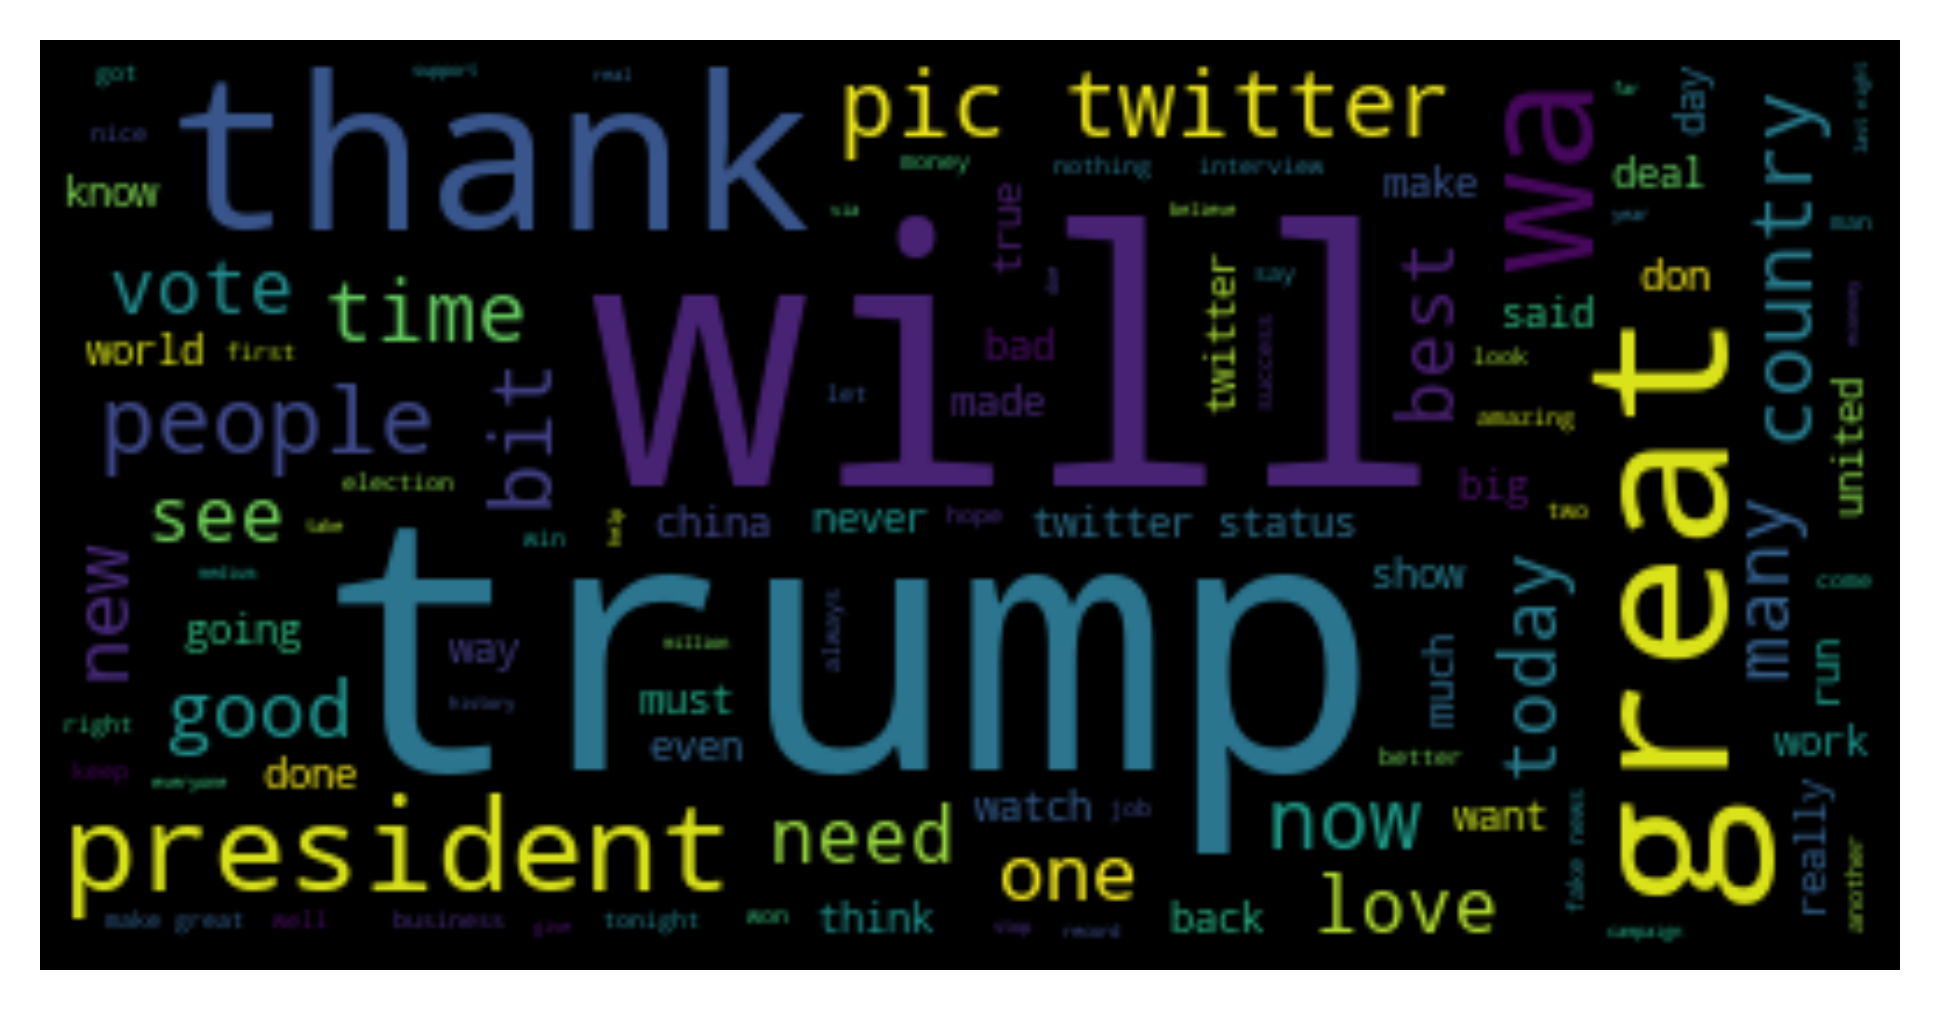

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
import warnings

warnings.filterwarnings('ignore')


def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


wc = WordCloud(max_words=1000, margin=10,
               random_state=1).generate(" ".join(third_clean_sentence))
# store default colored image
plt.rcParams['savefig.dpi'] = 1600  #图片像素
plt.rcParams['figure.dpi'] = 400  #分辨率
default_colors = wc.to_array()
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
count = TfidfVectorizer(stop_words='english')
sentence_count = count.fit_transform(third_clean_sentence)
ColumnNames = count.get_feature_names()
DF_TF = pd.DataFrame(sentence_count.toarray(), columns=ColumnNames)
DF_TF["text_label"] = [i for i in raw_text['label']]
# DF_TF is too heavy and we should subset part of it to train
dataset = DF_TF

In [6]:
dataset

abandon  abandoned  abatement  abbas  abhor  abiding  ability  abject  \
0         0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
1         0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
2         0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
3         0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
4         0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
...       ...        ...        ...    ...    ...      ...      ...     ...   
9995      0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
9996      0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
9997      0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
9998      0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   
9999      0.0        0.0        0.0    0.0    0.0      0.0      0.0     0.0   

      able  abnormally  ...  young  youngster  youth  yuan  zero  zone  \
0      0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
1      0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
2      0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
3      0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
4      0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
...    ...         ...  ...    ...        ...    ...   ...   ...   ...   
9995   0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
9996   0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
9997   0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
9998   0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   
9999   0.0         0.0  ...    0.0        0.0    0.0   0.0   0.0   0.0   

      zoning  zoo  zoom  text_label  
0        0.0  0.0   0.0           0  
1        0.0  0.0   0.0           1  
2        0.0  0.0   0.0           0  
3        0.0  0.0   0.0           0  
4        0.0  0.0   0.0           0  
...      ...  ...   ...         ...  
9995     0.0  0.0   0.0           1  
9996     0.0  0.0   0.0           1  
9997     0.0  0.0   0.0           0  
9998     0.0  0.0   0.0           1  
9999     0.0  0.0   0.0           0  

[10000 rows x 5766 columns]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:, :-1], dataset.iloc[:, -1:], test_size=0.3,
                                                    random_state=0)

In [96]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB()
model_nb.fit(X_train,y_train)
y_pred_nb = model_nb.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb.score(X_test, y_test)))

Accuracy on training set: 0.619
Accuracy on test set: 0.469


In [87]:
model_nb_2 = GaussianNB(var_smoothing=0.5)
model_nb_2.fit(X_train,y_train)
y_pred_nb_2 = model_nb_2.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb_2.score(X_test, y_test)))

Accuracy on training set: 0.869
Accuracy on test set: 0.823


In [91]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

z = confusion_matrix(y_test, y_pred_nb_2)

label_x = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']
label_y = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']

# change each element of z to type string for annotations
z_text = [[str(y) for y in label_x] for label_x in z]

# set up figure
fig = ff.create_annotated_heatmap(z, x=label_x, y=label_y, annotation_text=z_text, colorscale='Viridis')

# add title
# fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
#                   )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted Value in X Axis",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real Value in Y Axis",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [92]:
from sklearn.decomposition import PCA
import plotly.express as px

def show_2d_decision_boundary(model_nb):
    pca = PCA(n_components=2)
    X_train_de = pca.fit_transform(X_train)
    y_train_de = model_nb.predict(X_train)
    show_data = pd.DataFrame([X_train_de[:, 0].tolist(), X_train_de[:, 1].tolist(), y_train_de.tolist()])
    show_data = show_data.T
    show_data.columns = ["x", "y", "label"]
    fig = px.scatter(show_data, x="x", y="y", color="label",size_max=100)
    fig.update_traces(marker_size=6)
    fig.show()
    
def show_3d_decision_boundary(model_nb):
    pca = PCA(n_components=3)
    X_train_de = pca.fit_transform(X_train)
    y_train_de = model_nb.predict(X_train)
    show_data = pd.DataFrame([X_train_de[:, 0].tolist(), X_train_de[:, 1].tolist(), X_train_de[:, 2].tolist(),y_train_de.tolist()])
    show_data = show_data.T
    show_data.columns = ["x", "y", "z","label"]
    fig = px.scatter_3d(show_data, x="x", y="y", z="z",color="label",size_max=100)
    fig.update_traces(marker_size=6)
    fig.show()

In [95]:
show_2d_decision_boundary(model_nb_2)

In [94]:
show_3d_decision_boundary(model_nb_2)

In [53]:


from sklearn.naive_bayes import MultinomialNB

model_nb_2 = MultinomialNB()
model_nb_2.fit(X_train,y_train)
y_pred_nb_2 = model_nb_2.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb_2.score(X_test, y_test)))

Accuracy on training set: 0.866
Accuracy on test set: 0.831


In [54]:
model_nb_2_2 = MultinomialNB(alpha=0.3)
model_nb_2_2.fit(X_train,y_train)
y_pred_nb_2_2 = model_nb_2.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb_2_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb_2_2.score(X_test, y_test)))

Accuracy on training set: 0.918
Accuracy on test set: 0.861


In [67]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

z = confusion_matrix(y_test, y_pred_nb_2)

label_x = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']
label_y = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']

# change each element of z to type string for annotations
z_text = [[str(y) for y in label_x] for label_x in z]

# set up figure
fig = ff.create_annotated_heatmap(z, x=label_x, y=label_y, annotation_text=z_text, colorscale='Viridis')

# add title
# fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
#                   )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted Value in X Axis",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real Value in Y Axis",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [55]:
show_2d_decision_boundary(model_nb_2)



In [56]:
show_3d_decision_boundary(model_nb_2)

In [78]:
from sklearn.naive_bayes import BernoulliNB

model_nb_3 = BernoulliNB()
model_nb_3.fit(X_train,y_train)
y_pred_nb_3 = model_nb_3.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb_3.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb_3.score(X_test, y_test)))

Accuracy on training set: 0.908
Accuracy on test set: 0.878


In [80]:
model_nb_3_2 = BernoulliNB(alpha=0.1)
model_nb_3_2.fit(X_train,y_train)
y_pred_nb_3_2 = model_nb_3_2.predict(X_test)

print("Accuracy on training set: {:.3f}".format(model_nb_3_2.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model_nb_3_2.score(X_test, y_test)))

Accuracy on training set: 0.927
Accuracy on test set: 0.863


In [82]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

z = confusion_matrix(y_test, y_pred_nb_3)

label_x = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']
label_y = ['TrumpTweetsBeforePresident', 'TrumpTweetsAfterPresident']

# change each element of z to type string for annotations
z_text = [[str(y) for y in label_x] for label_x in z]

# set up figure
fig = ff.create_annotated_heatmap(z, x=label_x, y=label_y, annotation_text=z_text, colorscale='Viridis')

# add title
# fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
#                   )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted Value in X Axis",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real Value in Y Axis",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [83]:
show_2d_decision_boundary(model_nb_3)

In [84]:
show_3d_decision_boundary(model_nb_3_2)

In [13]:
from sklearn.svm import LinearSVC
model = LinearSVC(random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

/Users/junjiexie/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [14]:
print("Accuracy on training set: {:.3f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(model.score(X_test, y_test)))

Accuracy on training set: 0.976
Accuracy on test set: 0.857
